In [1]:
import torch
from policy_networks.mlp import PolicyNet
from policy_networks.rnn import RNNPolicyNet
from torch import optim
from tasks import RandomMaze
import numpy as np
from tasks.Env import Env
from tasks import Maze_config
from gvf_networks.tabular import Tabular
from utils import train_epoch
from IPython.display import clear_output
import matplotlib.pyplot as plt
import pickle
from mazelab.generators import random_maze
import gym
%matplotlib inline

In [1]:
# get gpu when available
if torch.cuda.is_available():
    use_gpu = True
    device = torch.device("cuda:0")
    print("GPU is available", flush=True)
else:
    use_gpu = False
    device = torch.device("cpu")
    print("no GPU found", flush=True)
    
    

In [1]:
# parameters
gammas = [0.98]
num_actions = 4
lr_adam = 5e-4
env_name = 'RandomMaze-v0'
size = 20
depth = 5
lr = {'sr': 0.3, 'gvfs': 0.6, 'Q': 0.1}
thresholds = {'sr': 0.6, 'gvfs': 0.1}
change = 50  # maze is changed every change epochs
batch_size = 1000
nb_epochs = 10000
nb_episodes_random_policy = 20
network = 'mlp' # or rnn
assert(network in ['mlp', 'rnn'])

# for plotting purposes
x_grid,y_grid = np.meshgrid(np.linspace(20,480,size),np.linspace(20,480,size))


# declare gvf network
gvf_net_xf = Tabular(size=size, num_actions=num_actions, depth=depth, gammas=gammas, 
                  thresholds=thresholds, lr=lr)
gvf_net_k1 = Tabular(size=size, num_actions=num_actions, depth=depth, gammas=gammas, 
                  thresholds=thresholds, lr=lr)
gvf_net_k2 = Tabular(size=size, num_actions=num_actions, depth=depth, gammas=gammas, 
                  thresholds=thresholds, lr=lr)

# declare policy network
logits_net = RNNPolicyNet(4 + (depth + 1) * num_actions * len(gammas), num_actions).to(device) if network == 'rnn' \
                    else PolicyNet(4 + (depth + 1) * num_actions * len(gammas), num_actions).to(device)

# make optimizer
optimizer = optim.Adam(logits_net.parameters(), lr=lr_adam)

# define environment
env, L = RandomMaze.main(env_name=env_name, size=size)

no GPU found


epoch:   2 	 loss: 0.000 	 return: -40.000 	 ep_len: 200.000


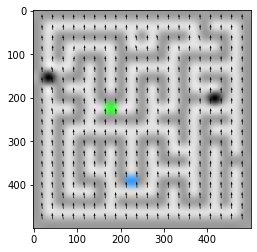

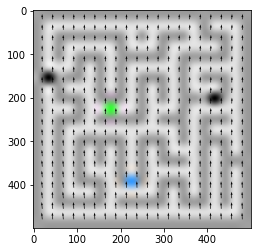

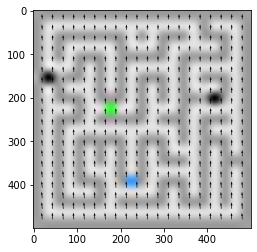

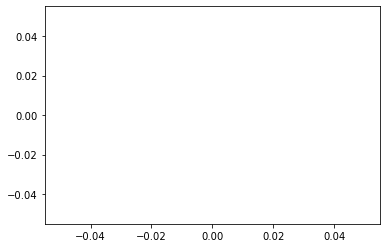

In [ ]:
total_reward = []

# training loop
for i in range(nb_epochs):
    clear_output(wait=True)
    
    # new network
    if i==0 or i%change==0:
        # reset gvf network
        gvf_net_xf.reset()
        gvf_net_k1.reset()
        gvf_net_k2.reset()
        # new environment
#         env, L = RandomMaze.main(start_position='goal_position',env_name=env_name, size=size)
        Maze_config.x = random_maze(width=size, height=size, complexity=1, density=0.5)
        Maze_config.xf_idx = [L[np.random.randint(0, len(L))]]
        Maze_config.k1_idx = [L[np.random.randint(0, len(L))]]
        Maze_config.k2_idx = [L[np.random.randint(0, len(L))]]
        Maze_config.start_idx = [L[np.random.randint(0, len(L))]]
        env.reset()
        
    elif np.any([(i-k)%change == 0 for k in range(1,2)]): # for first 3 episodes, start at goal
        # set start position to goal
        Maze_config.start_idx = Maze_config.k1_idx
    elif np.any([(i-k)%change == 0 for k in range(3,4)]): # for first 3 episodes, start at goal
        # set start position to goal
        Maze_config.start_idx = Maze_config.k2_idx
    elif np.any([(i-k)%change == 0 for k in range(5,6)]): # for first 3 episodes, start at goal
        # set start position to goal
        Maze_config.start_idx = Maze_config.xf_idx
    else:
        # random new position
        Maze_config.start_idx = [L[np.random.randint(0, len(L))]]
        
    #choose which subgoal is the target in this epoch:
    which_subgoal = np.random.randint(3)
#     which_subgoal = 2
    
    # training
    batch_loss, batch_rets, batch_lens = train_epoch(i, change, batch_size, env,  gvf_net_xf, gvf_net_k1, gvf_net_k2, logits_net, 
                                                     optimizer, device, nb_episodes_random_policy, which_subgoal)

    print('epoch: %3d \t loss: %.3f \t return: %.3f \t ep_len: %.3f'%
            (i, batch_loss, np.mean(batch_rets), np.mean(batch_lens)))

    if np.all([(i - k) % change != 0 for k in range(nb_episodes_random_policy)]):
        total_reward.append(np.mean(batch_lens))

    policy_all_states_k1 = logits_net.get_policy_all_states(env, gvf_net_k1,0, device)
    policy_all_states_k2 = logits_net.get_policy_all_states(env, gvf_net_k2,1, device)
    policy_all_states_xf = logits_net.get_policy_all_states(env, gvf_net_xf,2, device)

    # figure of gvfs        
#     plt.figure()
#     for i_plot in range(20):
#         plt.subplot(5, 4, i_plot + 1)
#         plt.imshow(gvf_net_k1.gvfs[int(i_plot/4), :, :, -1, int(i_plot%4)])
#         if i_plot <= 3:
#             plt.title(np.array(['down', 'up', 'left', 'right'])[i_plot])
#         plt.colorbar()
        
#     plt.figure()   
#     for i_plot in range(20):
#         plt.subplot(5, 4, i_plot + 1)
#         plt.imshow(gvf_net_k2.gvfs[int(i_plot/4), :, :, -1, int(i_plot%4)])
#         if i_plot <= 3:
#             plt.title(np.array(['down', 'up', 'left', 'right'])[i_plot])
#         plt.colorbar()
        
#     plt.figure()    
#     for i_plot in range(20):
#         plt.subplot(5, 4, i_plot + 1)
#         plt.imshow(gvf_net_xf.gvfs[int(i_plot/4), :, :, -1, int(i_plot%4)])
#         if i_plot <= 3:
#             plt.title(np.array(['down', 'up', 'left', 'right'])[i_plot])
#         plt.colorbar()

    # figure of policy network
    plt.figure()
    img = env.render('rgb_array')    
    plt.imshow(img)
    plt.quiver(x_grid, 
               y_grid, 
               policy_all_states_k1[:,:,3] - policy_all_states_k1[:,:,2],
               policy_all_states_k1[:,:,0] - policy_all_states_k1[:,:,1])
    
    plt.figure()
    plt.imshow(img)
    plt.quiver(x_grid, 
               y_grid, 
               policy_all_states_k2[:,:,3] - policy_all_states_k2[:,:,2],
               policy_all_states_k2[:,:,0] - policy_all_states_k2[:,:,1])
    
    plt.figure()
    plt.imshow(img)
    plt.quiver(x_grid, 
               y_grid, 
               policy_all_states_xf[:,:,3] - policy_all_states_xf[:,:,2],
               policy_all_states_xf[:,:,0] - policy_all_states_xf[:,:,1])

    # figure of reward
    plt.figure()
    plt.plot(total_reward)
    plt.show()

/opt/anaconda3/envs/virtEnv/lib/python3.7/site-packages/scipy/signal/_savitzky_golay.py:135: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  coeffs, _, _, _ = lstsq(A, y)
/opt/anaconda3/envs/virtEnv/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


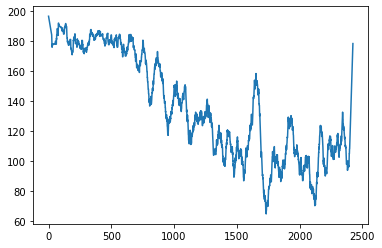

In [3]:
from scipy.signal import savgol_filter
plt.figure()
plt.plot(savgol_filter(total_reward,51,1))
plt.show()